<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/N2_O2_CO2_NVT_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install

In [1]:
# jax molecular dynamics
!pip install jax-md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 1.6 MB/s 
     |████████████████████████████████| 90 kB 4.8 MB/s 
     |████████████████████████████████| 342 kB 44.4 MB/s 


Import

In [2]:

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')


  


Experiment configuration

In [3]:
N = 400
dimension = 2
box_size = quantity.box_size_at_number_density(N, 0.8, 2)
dt = 5e-3
displacement, shift = space.periodic(box_size) 

write_every = 100


kT = lambda t: np.where(t < 5000.0 * dt, 0.01, 0.012)

Helper functions

In [4]:
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

In [5]:
def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

In [6]:
def step_fn(i, state_and_log):
  state, log = state_and_log

  t = i * dt

  # Log information about the simulation.
  T = quantity.temperature(state.velocity)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT(t))
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT(t))



  return state, log

In [7]:
key = random.PRNGKey(0)

In [8]:
key, split = random.split(key)
R = box_size * random.uniform(split, (N, dimension), dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 5)
N_3 = int(N / 50)

buf = 0
buf_lst = []
for i in range(0, N):

  if buf < N_3:
    buf_lst.append(0)
  elif buf < N_2:
    buf_lst.append(1)
  else:
    buf_lst.append(2)

  buf += 1

In [9]:
species = np.array(buf_lst)


In [10]:
species.shape

(400,)

In [11]:
energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT(0.))
state = init(key, R)

In [12]:
steps = 10000

log = {
    'kT': np.zeros((steps,)),
    'H': np.zeros((steps,)),
    'position': np.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

R = state.position

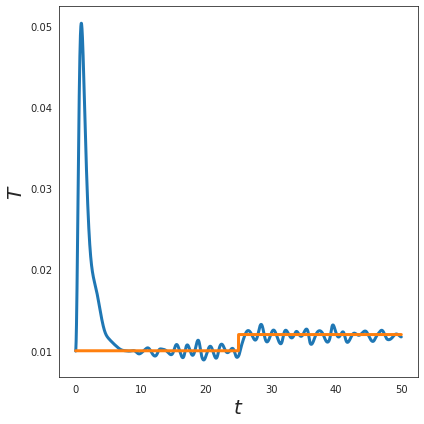

In [13]:
t = onp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT(t), linewidth=3)
format_plot('$t$', '$T$')
finalize_plot()

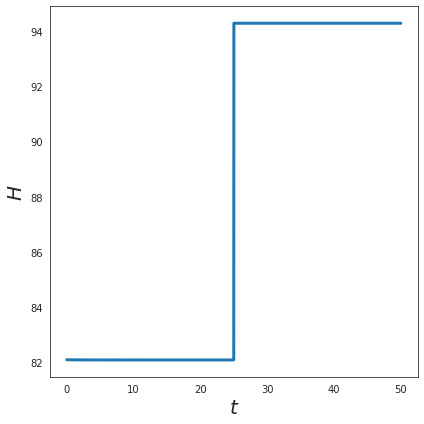

In [14]:
plt.plot(t, log['H'], linewidth=3)
format_plot('$t$', '$H$')
finalize_plot()

In [15]:
buf_lst = []
for i in species:
   
  # carbon dioxide
  if i == 0: 
    buf_lst.append(np.array([1.5, 3.2, 0.01]))
  
  # oxygen
  elif i == 1: 
    buf_lst.append(np.array([1.0, 0.2, 0.5]))   

  # nitrogen
  elif i == 2: 
    buf_lst.append(np.array([0.3, .8, 0.85]))        


In [20]:
from jax_md.colab_tools import renderer

diameters = sigma[species, species]

colors = np.array(buf_lst)

renderer.render(box_size,
                {
                    'particles': renderer.Disk(log['position'], 
                                               diameters,
                                               colors)
                },
                resolution=(600, 600))

In [17]:
log['position'].shape

(100, 400, 2)

In [18]:
initial_positions = log['position'][0]

In [19]:
log['position'][1]

DeviceArray([[1.62935389e+01, 1.87759197e+01],
             [1.71384875e+01, 1.00627576e+01],
             [1.34282364e+01, 1.27085293e+01],
             [1.95254715e+01, 1.24869332e+01],
             [1.96764249e+01, 1.62716396e+01],
             [1.88981278e+01, 2.02318571e+01],
             [9.66211152e+00, 1.12550371e+01],
             [3.60473769e+00, 2.21966525e+01],
             [4.85872006e+00, 1.34077930e+01],
             [8.23190066e+00, 1.78202987e+01],
             [2.62308394e+00, 4.91765206e+00],
             [1.15539759e+01, 6.18743222e+00],
             [2.15294137e+00, 9.03273404e+00],
             [9.51666759e+00, 1.60436127e+01],
             [1.20439904e+01, 1.58551808e+01],
             [8.90329454e+00, 1.51717547e+01],
             [1.65860881e+01, 6.90262781e+00],
             [3.51479496e+00, 1.76041459e+01],
             [3.08497828e+00, 3.49940797e+00],
             [1.13694245e+01, 1.05495752e+01],
             [1.17551567e+01, 1.65915173e+01],
             

In [25]:
import imageio
import jax.numpy as jnp

def make_from_image(filename, size_in_pixels):
  position = []
  angle = []
  color = []

  img = imageio.imread(filename)

  scale = 2**(1/6)
  ratio = jnp.sqrt(1 - 0.25)
  for i, y in enumerate(range(0, img.shape[0], size_in_pixels)):
    for x in range(0, img.shape[1], size_in_pixels):
      r, g, b, a = img[y, x]
      if a == 255:
        hshift = size_in_pixels * (i % 2) / 2.0
        position += [[scale * (x + hshift) / size_in_pixels, scale * (img.shape[0] - y) / size_in_pixels * ratio]]
        color += [[r / 255, g / 255, b / 255]]
  img_size = jnp.array(img.shape[:2]).T / size_in_pixels * scale
  box_size = jnp.max(img_size) * 1.5
  position = jnp.array(position, jnp.float64) + box_size / 2.0 - img_size / 2
  color = jnp.array(color, jnp.float64)

  return box_size, position, color

In [27]:
make_from_image('mfi_two.png', 24)

ValueError: ignored